# Сюжет "сети сопротивлений"

## Содержание
1. [Сети сопротивлений](#Сети-сопротивлений)
2. [Правила Кирхгофа и системы уравнений](#Правила-Кирхгофа-и-системы-уравнений)
3. [Код](#Код)
4. [Регулярная решётка](#Регулярная-решётка)
5. [См. также](#См.-также)
5. [В лаборатории](#В-лаборатории)
7. [Литература](#Литература)

## Сети сопротивлений

In [ ]:
from IPython.display import Image
display(Image(filename='figures/slides-1.png'))

In [ ]:
display(Image(filename='figures/slides-2.png'))

## Правила Кирхгофа и системы уравнений

In [ ]:
for i in range(3, 10):
    display(Image(filename='figures/slides-{}.png'.format(i)))

## Код

In [1]:
import numpy as np
import scipy as sp

In [2]:
class Graph:
    """
    Ненаправленный взвешенный граф
    """
    def __init__(self):
        self.edges = {}
    
    
    @property
    def nodes(self):
        return self.edges.keys()
    
    
    def add_node(self, v):
        """
        Добавить вершину
        """
        if v not in self.edges:
            self.edges[v] = {}
    
    
    def add_edge(self, a, b, weight):
        """
        Добавить ребро
        """
        self.add_node(a)
        self.add_node(b)
        
        if a != b:
            self.edges[a][b] = weight
            self.edges[b][a] = weight

            
    def del_node(self, v):
        """
        Удалить вершину
        """
        ws = self.edges[v]
        del self.edges[v]
        for w in ws:
            del self.edges[w][v]

            
    def del_edge(self, a, b):
        """
        Удалить ребро
        """
        del self.edges[a][b]
        del self.edges[b][a]

        
    def is_connected(self):
        """
        Проверить граф на связность
        """
        if len(self.nodes) <= 1:
            return True
        
        component = set()
        to_visit = {next(iter(self.nodes))}
        
        while len(to_visit) > 0:
            v = to_visit.pop()
            if v not in component:
                component.add(v)
                to_visit.update(self.edges[v])
        
        not_visited = set(self.nodes).difference(component)
        
        return len(not_visited) == 0

In [3]:
class Circuit(Graph):
    """
    Цепь сопротивлений как расширение понятия "ненаправленный взвешенный граф"
    """
    def __init__(self, n=0):
        super(Circuit, self).__init__()
    
    
    def _equations(self):
        """
        Служебная функция, вычисляющая уравнения для потенциала во всех вершинах
        """
        if not self.is_connected():
            raise ValueError('solution existance in disconnected circit is not guranteed.')
            
        node_list = sorted(list(self.nodes))
        node_index = dict((v, i) for i, v in enumerate(node_list))
        nodes = len(node_list)

        eqs = np.zeros((nodes, nodes))
        
        for v_index in range(len(node_list)):
            v = node_list[v_index]
            for w, edge in self.edges[v].items():
                w_index = node_index[w]
                eqs[v_index, v_index] += 1 / edge
                eqs[v_index, w_index] -= 1 / edge

        return node_list, eqs

    
    def measure_resistance(self, v, w):
        """
        Измерение эквивалентного сопротивления между двумя вершинами
        """
        potentials = self.probe_field(v, w)
        currents = self.calculate_currents(potentials)
        return 1 / sum(currents[w].values())

    
    def probe_field(self, v, w):
        """
        Вычисление поля потенциала при подключении вольтметра к двум вершинам
        """
        if v == w:
            raise ValueError('Short circuit in probe field.')

        node_list, eqs = self._equations()
        
        v_index = node_list.index(v)
        w_index = node_list.index(w)
        
        eqs[v_index] = 0
        eqs[w_index] = 0
        eqs[v_index, v_index] = 1
        eqs[w_index, w_index] = 1

        rhs = np.zeros(len(node_list))
        rhs[v_index] = 0
        rhs[w_index] = 1
        
        potentials = np.linalg.solve(eqs, rhs)

        return dict(zip(node_list, potentials))
    
    
    def calculate_currents(self, potentials):
        """
        Вычисление поля токов из поля потенциалов
        """
        currents = {}
        for v in self.nodes:
            currents[v] = {}
            for w, edge in self.edges[v].items():
                currents[v][w] = (potentials[v] - potentials[w]) / edge
        
        return currents

In [4]:
# Пример для неформального теста

c = Circuit()
c.add_edge('a', 'b', 10)
c.add_edge('b', 'd', 20)
c.add_edge('a', 'c', 20)
c.add_edge('c', 'd', 30)
c.measure_resistance('a', 'd')

18.749999999999996

In [ ]:
display(Image(filename='figures/slides-10.png'))

Возможные задачи для кодинга:
    
* Реализовать Graph и Circuit с заданными интерфейсами.
* Написать тесты. В том числе рандомизированные.

Возможная задача для творческого развития:
* Из ограниченного объёма резисторов сопротивлением 10 Ом составить схемы, реализующие следующие эквивалентные сопротивления:
 1. 4 Ом и 6 Ом -- не более четырёх резисторов;
 2. 8 Ом -- не более пяти;
 3. 3 Ом и 7 Ом -- не более шести.

## Регулярная решётка

In [ ]:
for i in range(11, 34):
    display(Image(filename='figures/slides-{}.png'.format(i)))

In [5]:
import matplotlib.pyplot as plt


class GridCircuit(Circuit):
    """
    Прямоугольные решётки из цепей сопротивлений
    """
    def __init__(self, n, inner_weight=1, outer_weight=1):
        super(Circuit, self).__init__()
        self.size = n
        for i in range(-n, n):
            for j in range(-n, n):
                self.add_edge((i, j), (i + 1, j), inner_weight)
                self.add_edge((i, j), (i, j + 1), inner_weight)
        
        for i in range(-n, n):
            self.add_edge((i, n), (i + 1, n), outer_weight)
            self.add_edge((n, i), (n, i + 1), outer_weight)
            self.add_edge((i, -n), (i + 1, -n), outer_weight)
            self.add_edge((-n, i), (-n, i + 1), outer_weight)

    
    def plot_field(self, potentials):
        """
        Отрисовка поля токов
        """
        plt.figure(figsize=(6, 6))
        plt.axes()
        plt.axis('off')
        
        currents = self.calculate_currents(potentials)
        maxcur = max(abs(np.array([c for d in currents.values() for _, c in d.items()])))
        
        for u in self.nodes:
            for w, current in currents[u].items():
                v = u
                if v >= w:
                    continue

                if current < 0:
                    v, w = w, v
                    current = -current

                plt.arrow(v[0], v[1], w[0] - v[0], w[1] - v[1], width=0.1, length_includes_head=True, alpha=current / maxcur)
        
        plt.axis('scaled')
    
    
    def central_field(self, v=(0, 0)):
        """
        Вычисление единичного центрального поля, т.е. нахождение фундаментального решения.
        """
        n = self.size
        
        i, j = v
        if abs(i) == n or abs(j) == n:
            raise ValueError('central field for boundary source')
            
        node_list, eqs = self._equations()
        nn = len(node_list)
        node_index = dict(zip(node_list, range(nn)))

        v_index = node_index[v]
        eqs[v_index] = 0
        eqs[v_index, v_index] = 1

        rhs = np.zeros(nn)
        rhs[v_index] = 1
        
        for i in range(-n, n + 1):
            for w in [(n, i), (-n, i), (i, n), (i, -n)]:
                w_index = node_index[w]
                eqs[w_index] = 0
                eqs[w_index, w_index] = 1
                # rhs[w_index] = 0

        potentials = np.linalg.solve(eqs, rhs)

        return dict(zip(node_list, potentials))

In [6]:
# Возьмём решётку сопротивлений 14x14
g = GridCircuit(7)

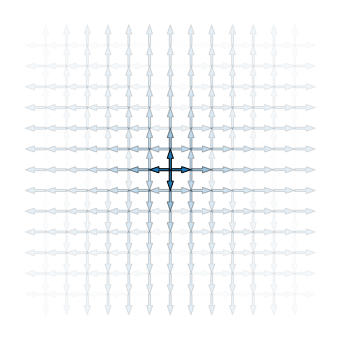

In [7]:
# Центральное поле
potentials = g.central_field((0, 0))
g.plot_field(potentials)

0.6366197723675814

0.6416344934655924

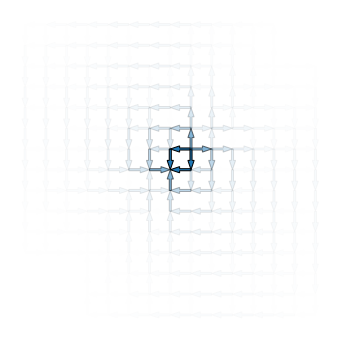

In [8]:
# Сопротивление между точками (0, 0) и (1, 1)
display(2 / np.pi)
display(g.measure_resistance((0, 0), (1, 1)))

# И поле
potentials = g.probe_field((0, 0), (1, 1))
g.plot_field(potentials)

0.7267604552648372

0.7365200617579011

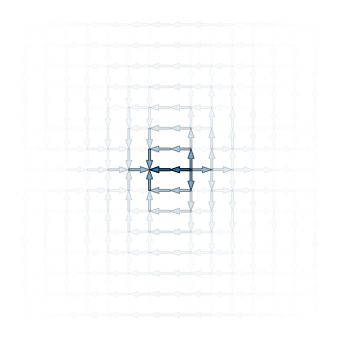

In [9]:
# Сопротивление между точками (-1, 0) и (1, 0)
display(2 * (1 - 2 / np.pi))
display(g.measure_resistance((-1, 0), (1, 0)))

# И поле
potentials = g.probe_field((-1, 0), (1, 0))
g.plot_field(potentials)

0.7732395447351628

0.7856096240861956

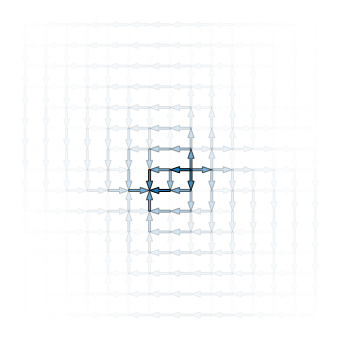

In [10]:
# Сопротивление между точками (-1, -1) и (1, 0)
display((4 / np.pi - 1 / 2))
display(g.measure_resistance((-1, -1), (1, 0)))

# И поле
potentials = g.probe_field((-1, -1), (1, 0))
g.plot_field(potentials)

In [11]:
# Для более точной оценки посмотрим решётку 40x40:
g = GridCircuit(20)

# Сопротивление между точками (-1, -1) и (1, 0)
display((4 / np.pi - 1 / 2))
display(g.measure_resistance((-1, -1), (1, 0)))

0.7732395447351628

0.7748706585472928

## См. также

In [ ]:
for i in range(34, 39):
    display(Image(filename='figures/slides-{}.png'.format(i)))

## В лаборатории

In [ ]:
display(Image(filename='figures/slides-39.png'))

## Литература
1. Соболев -- Об одном разностном уравнении.
2. Соболев -- Об единственности решения разностных уравнений эллиптического типа.
3. Lynch -- Fundamental Solutions of 9-point Discrete Laplacians.
4. Kac -- Probability and Related Topics in Physical Sciences-Interscience (Annex by Van der Pol).
5. McCrea, Whipple -- Random Paths in Two and Three Dimensions.
6. Duffin -- Basic properties of discrete analytic functions.
7. Duffin, Shelly -- Difference equations of polyharmonic type.